# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ0618+5018

**Authors**: Ahmad Al - Imtiaz, Sulyman Hossain, S M Rafee Adnan, Anowar Shajib <br>
**Acknowledgement(s)**: Mamunur Rashid

## Import Libraries

In [1]:
!pip install pandas
!pip install yaml
!pip install astropy
!pip install photutils

ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

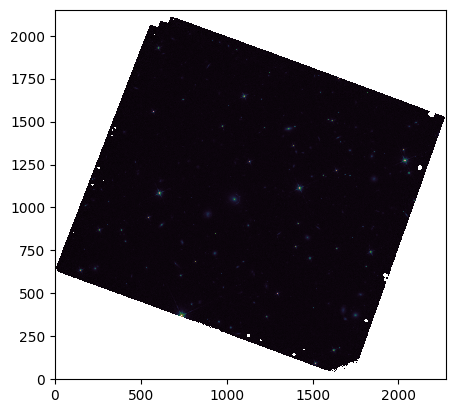

In [3]:
data, header = fits.getdata(
    "/kaggle/input/fits-file/DESIJ06185018_F140W_drz_sci.fits", header=True
)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_18/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


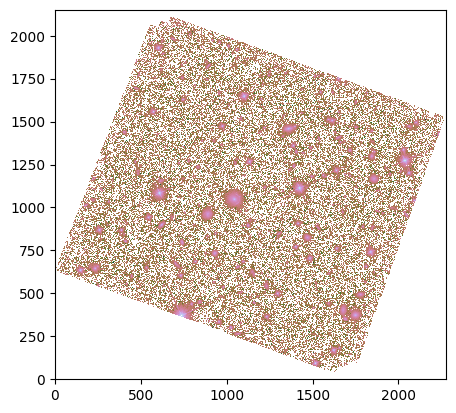

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_18/1110924231.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


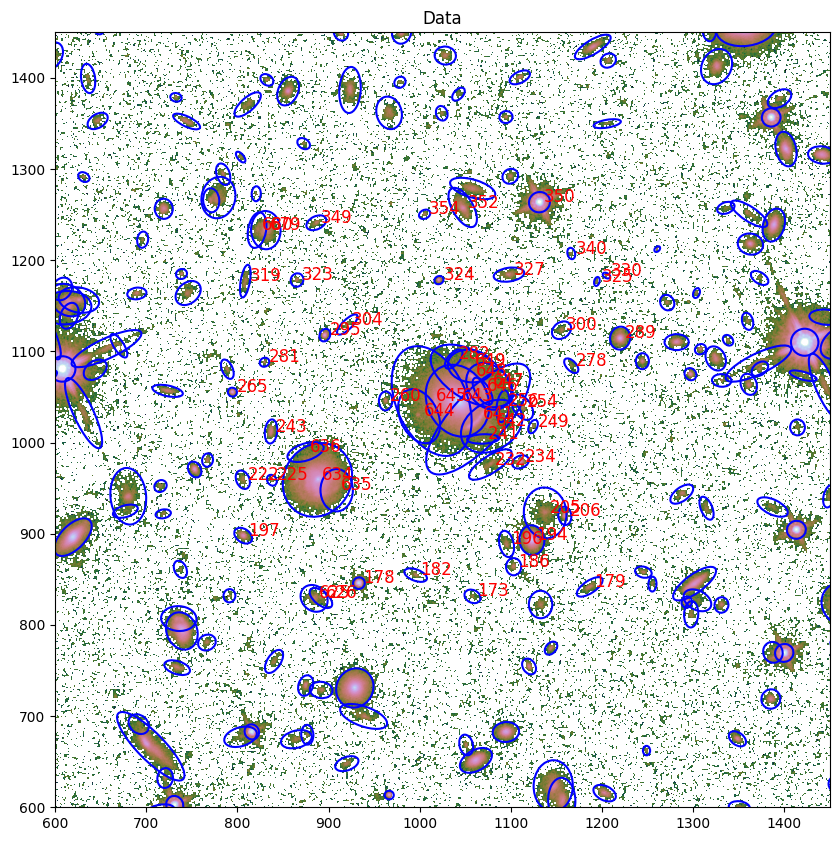

In [5]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[645]) < 220
        and np.abs(cat.ycentroid[i] - cat.ycentroid[645]) < 220
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 600, 1450
set_y_lim1, set_y_lim2 = 600, 1450

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_18/598093144.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


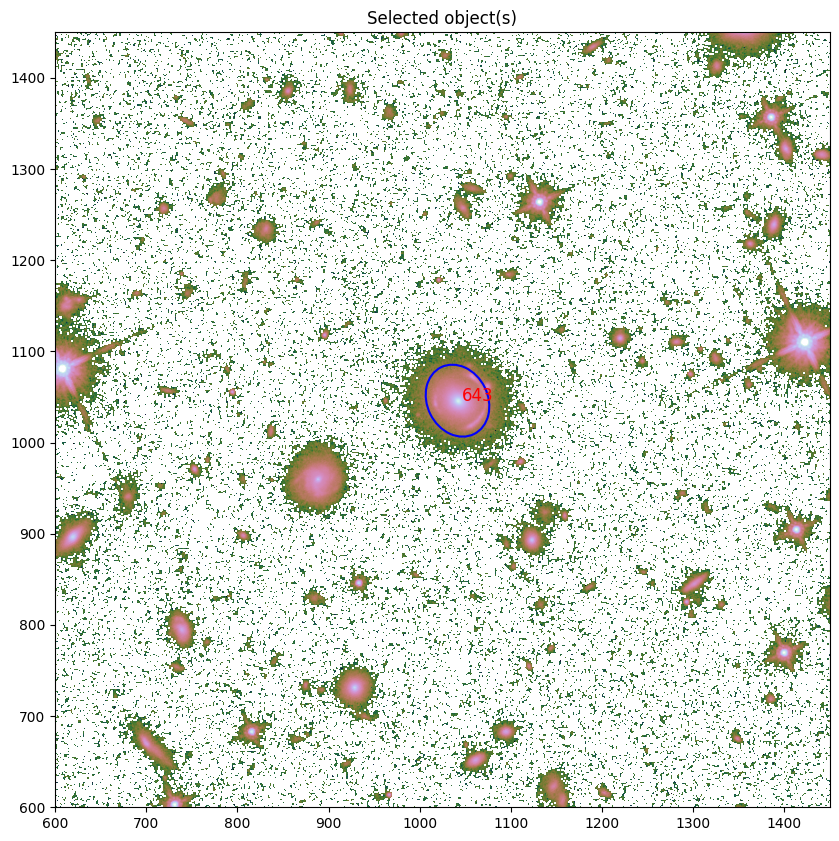

In [6]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = 643

# Calling the function label id_central
label_selected_objects([id_central])

In [7]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [8]:
# All close galaxies
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 30 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 30 arcsecond radius: 119


In [9]:
# Close galaxies excluding sources lower than 1% of the central deflector
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 30 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 30 arcsecond radius: 31


## Pixels to Megaparsec unit

In [10]:
def distance_parsec(pixel_distance, z):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :param z: photometric redshift

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180

    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian

    # Define cosmological parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Om0 = 0.3  # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)

    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian

    return physical_distances_mpc

## Identify the unwanted objects

/tmp/ipykernel_18/598093144.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


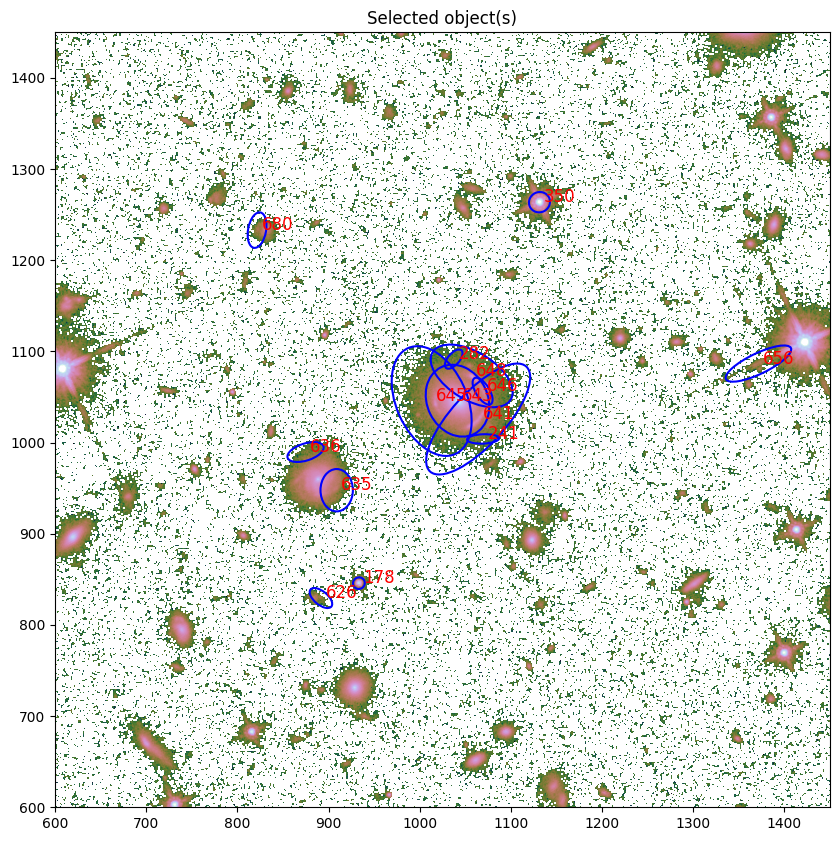

In [11]:
unwanted_object_ids = [
    178,
    241,
    282,
    350,
    626,
    635,
    636,
    641,
    643,
    645,
    646,
    648,
    656,
    680,
]
label_selected_objects(unwanted_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [12]:
# All close galaxies
remove_list = [
    178,  # star
    241,  # unnecessary artifact
    282,  # unnecessary artifacts
    350,  # star
    626,  # artifact of 626
    635,  # artifact of 635
    636,  # artifact of 635
    641,  # part of the arc
    643,  # central deflector
    645,  # part of the arc
    646,  # part of the arc
    648,  # part of the arc
    656,  # diffraction spike
    680,  # artifact of 680
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

# Photometric redshift of the deflector galaxy is 0.519
df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"], 0.519)
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
647         37.587807              0.018719   98.152147    0.786945
649         40.499925              0.020170   48.155922    0.716356
644         45.456548              0.022638   50.126776    0.661228
642         46.734417              0.023275   75.959023    0.721411
256         50.244410              0.025023   13.244352    0.391556
254         71.460055              0.035588    8.816965    0.614738
232         78.701359              0.039195   15.069394    0.346842
260         78.826650              0.039257    6.627064    0.710901
249         87.571107              0.043612    2.620894    0.566593
234         96.353995              0.047986   16.256545    0.698932
278        130.524526              0.065003    2.565852    0.540374
324        133.767644              0.066619   10.438994    0.848953
300        137.804441              0.068629    5.492211    0.758432
304        146.921980              0.073170    3

In [13]:
# Excluding galaxies lower than 1% of the central deflector
remove_list_1 = [
    178,  # star
    350,  # star
    635,  # artifact of 635
    641,  # part of the arc
    643,  # central deflector
    645,  # part of the arc
    646,  # part of the arc
    648,  # part of the arc
    656,  # diffraction spike
]
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

# Photometric redshift of the deflector galaxy is 0.519
df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"], 0.519)
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
647         37.587807              0.018719   98.152147    0.786945
649         40.499925              0.020170   48.155922    0.716356
644         45.456548              0.022638   50.126776    0.661228
642         46.734417              0.023275   75.959023    0.721411
205        156.205228              0.077793   38.200417    0.834625
295        162.284280              0.080820   22.838049    0.788046
194        173.398543              0.086355  203.417314    0.836395
634        176.485316              0.087893  877.783242    0.883562
289        191.107462              0.095175   67.562651    0.877191
352        211.954442              0.105557   44.546534    0.467997
363        233.268784              0.116172   23.246863    0.380471
290        248.763145              0.123888   28.670890    0.658721
679        281.415143              0.140149   54.652352    0.769469
280        286.973686              0.142918   22

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

## Loading Global Mean

In [14]:
# Read flux data from each YAML file and append to corresponding lists
input_path = "/kaggle/input/global-means/DESIJ06185018_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load the file: {e}")

global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Method A

In [15]:
# For all sources
R_10_all = df_all_20.iloc[
    9, df_all_20.columns.get_loc("Distance(megaparsec)")
]  ## Change
R_20_all = df_all_20.iloc[
    19, df_all_20.columns.get_loc("Distance(megaparsec)")
]  ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")]  ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")]  ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.04798588845251906
R 20: 0.08635535156355582
Sigma 10: 1382.3660111220374
Sigma 20: 853.6927826725971

EXCLUDING DIM SOURCES
R 10: 0.10555682934394171
R 20: 0.17956112982259093
Sigma 10: 285.67843233923566
Sigma 20: 197.44923899012213


## Method B

In [16]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10]) / global_mean_flux_10
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20]) / global_mean_flux_20
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10]) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20]) / global_mean_flux_selected_20
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.04798588845251906
R 20: 0.08635535156355582
Sigma 10_updated: 200.15798448121413
Sigma 20_updated: 160.38167685553253

EXCLUDING DIM SOURCES
R 10: 0.10555682934394171
R 20: 0.17956112982259093
Sigma 10_updated: 108.65471802089655
Sigma 20_updated: 69.60533073507911


## Method C

In [17]:
flux_c_10_all = []
flux_c_20_all = []
flux_c_10_1 = []
flux_c_20_1 = []

# for all sources
for i in range(20):
    flux_all = (
        df_all_20["Flux"][i : i + 1] / df_all_20["Distance(megaparsec)"][i : i + 1]
    )

    if i < 10:
        flux_c_10_all.append(flux_all)
        flux_c_20_all.append(flux_all)

    elif 9 < i < 20:
        flux_c_20_all.append(flux_all)

weighted_flux_10_all = np.sum(flux_c_10_all) / global_mean_flux_10
weighted_flux_20_all = np.sum(flux_c_20_all) / global_mean_flux_20
Sigma_10_allC = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i : i + 1] / df_1_20["Distance(megaparsec)"][i : i + 1]

    if i < 10:
        flux_c_10_1.append(flux_1)
        flux_c_20_1.append(flux_1)

    elif 9 < i < 20:
        flux_c_20_1.append(flux_1)

weighted_flux_10_1 = np.sum(flux_c_10_1) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(flux_c_20_1) / global_mean_flux_selected_20
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.04798588845251906
R 20: 0.08635535156355582
Sigma 10_updated: 8864.725568002987
Sigma 20_updated: 4571.210404237798

EXCLUDING DIM SOURCES
R 10: 0.10555682934394171
R 20: 0.17956112982259093
Sigma 10_updated: 1946.9263772063223
Sigma 20_updated: 961.5780009821207


## Method D

In [18]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125  # for 10 arcseconds

# Mean Photometric redshift of all the deflectors is 0.581
s = distance_parsec(pixel_distance, 0.581).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]

    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)

    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_20_all.append(flux_contrib_all)

    # Processing for df_1_20
    if i < 10:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)

    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_20
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_selected_20
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.04798588845251906
R 20: 0.08635535156355582
Sigma 10_updated: 3039.539003655634
Sigma 20_updated: 2192.6800112192104

EXCLUDING DIM SOURCES
R 10: 0.10555682934394171
R 20: 0.17956112982259093
Sigma 10_updated: 1308.389580573829
Sigma 20_updated: 696.5780796997803


## Visualization

/tmp/ipykernel_18/3331231841.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/3331231841.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/3331231841.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/3331231841.py:29: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


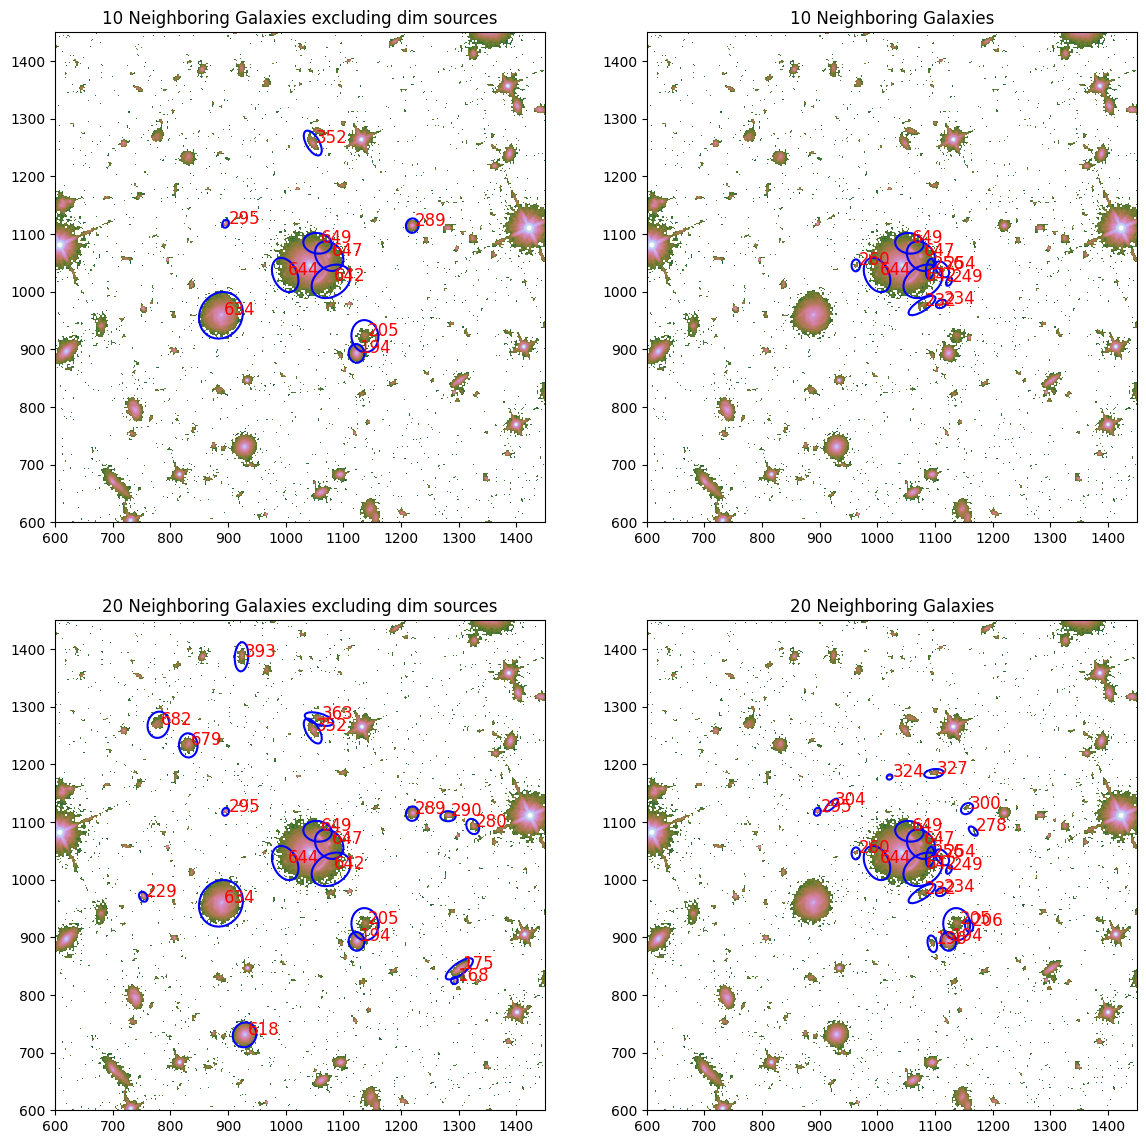

In [19]:
close_ids_all = list(df_all_20.index.values)
# close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
# close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]


simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [20]:
src_path = r"/kaggle/input/point-estimates/DESIJ06185018_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ06185018_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [21]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 32
{'R_eff_light': 0.8194236223102188, 'Sigma_10a': 1382.3660111220374, 'Sigma_10a_flux_selected': 285.67843233923566, 'Sigma_10b': 200.15798448121413, 'Sigma_10b_flux_selected': 108.65471802089655, 'Sigma_10c': 8864.725568002987, 'Sigma_10c_flux_selected': 1946.9263772063223, 'Sigma_10d': 3039.539003655634, 'Sigma_10d_flux_selected': 1308.389580573829, 'Sigma_20a': 853.6927826725971, 'Sigma_20a_flux_selected': 197.44923899012213, 'Sigma_20b': 160.38167685553253, 'Sigma_20b_flux_selected': 69.60533073507911, 'Sigma_20c': 4571.210404237798, 'Sigma_20c_flux_selected': 961.5780009821207, 'Sigma_20d': 2192.6800112192104, 'Sigma_20d_flux_selected': 696.5780796997803, 'center_x_light': [-0.17150506588084782, 0.0008462895042265495, 0.0006756127818671742], 'center_x_mass': [-0.43596095614981645, 0.0011875616155935798, 0.001476021041531328], 'center_y_light': [-0.020121544660983974, 0.00051480747842109, 0.0005444647451639112], 'center_y_mass': [0.08456579623020608, 

## Determining the mean for normalizing

In [22]:
# Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:10])
flux_20_mean = np.mean(df_all_20["Flux"][0:20])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:10])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:20])

# Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

33.50290827178561 32.87442146491986 152.6742076137236 117.83377075126643
508.76509719024926 449.447145333541 1838.4599040213245 1179.2260863769607


In [23]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean,
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [24]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ0618+5018_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ0618+5018_means.yml' created successfully.
